In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import *
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.metrics import *
warnings.simplefilter("ignore")

In [ ]:
df = pd.read_csv("ETH_1H.csv")
df.head()

In [ ]:
df.nunique()

In [ ]:
df_1 = df.drop(columns=["Symbol","Unix Timestamp"])
df_1.head()

In [ ]:
df_2 = df_1.copy()
df_2["Date"] = pd.to_datetime(df_2["Date"]).dt.date
grps_mean = df_2.groupby(by="Date").mean()[["Open","Close","Volume"]].reset_index()
grps_max = df_2.groupby(by="Date").max()[["High"]].reset_index()
grps_min = df_2.groupby(by="Date").min()[["Low"]].reset_index()

grps_min_max = pd.merge(left=grps_min,right=grps_max,how="inner",on="Date")
grps = pd.merge(left=grps_min_max,right=grps_mean,how="inner",on="Date")

df_3 = grps.set_index("Date")
df_3 = df_3.round(2)
df_3.reset_index(inplace=True)
df_3.head()

In [ ]:
cols = df_3.columns.values[1:]
cols

In [ ]:
for i in cols:
    plt.subplots(figsize=(10,3))
    sns.lineplot(x=df_3["Date"],y=df_3[i])
    plt.title("Plot for "+i)
    plt.xlabel("Date ---------->")
    plt.ylabel("Open ---------->")
    plt.show()

In [ ]:
plt.subplots(figsize=(10,10))
df_4 = df_3.set_index("Date")
sns.heatmap(df_4.corr(),annot=True)

In [ ]:
df_5 = df_1.drop(columns=["High","Low","Open","Volume"])
df_5["Date"] = pd.to_datetime(df_5["Date"])
df_5 = df_5.sort_values(by="Date").reset_index(drop=True)
df_5.head()

In [10]:
dates = pd.to_datetime(df_5["Date"]).values
close = df_5["Close"].values

In [11]:
window_size = 240
initial_step = 0
final_step = close.shape[0] - window_size
X = []
y = []
window_dates = []
for i in range(initial_step,final_step):
    initial_index = i
    final_index = i + window_size
    window_values = close[initial_index:final_index]
    target_value = close[final_index]
    X.append(window_values)
    y.append(target_value)
    window_dates.append(dates[final_index])
X = np.array(X)
y = np.array(y)
window_dates = np.array(window_dates)

In [12]:
window_dates

array(['2016-05-19T13:00:00.000000000', '2016-05-19T14:00:00.000000000',
       '2016-05-19T15:00:00.000000000', ...,
       '2020-04-15T22:00:00.000000000', '2020-04-15T23:00:00.000000000',
       '2020-04-16T00:00:00.000000000'], dtype='datetime64[ns]')

In [13]:
mms = MinMaxScaler()
X_scaled = mms.fit_transform(X)
y_scaled = mms.fit_transform(y.reshape(-1,1))

In [14]:
val_test_threshold = round(X.shape[0] * 0.8)
train_val_threshold = round(val_test_threshold * 0.8)

train_length = train_val_threshold
X_train = X_scaled[:train_val_threshold].reshape(train_length,1,window_size)
y_train = y_scaled[:train_val_threshold]

val_length = val_test_threshold - train_val_threshold
X_val = X_scaled[train_val_threshold:val_test_threshold].reshape(val_length,1,window_size)
y_val = y_scaled[train_val_threshold:val_test_threshold]

test_length = X.shape[0] - val_test_threshold
X_test = X_scaled[val_test_threshold:].reshape(test_length,1,window_size)
y_test = y_scaled[val_test_threshold:]
test_dates = window_dates[val_test_threshold:]

In [15]:
X_train[0].shape

(1, 240)

In [16]:
X_train.shape

(21925, 1, 240)

### Implementation of LSTM model

In [17]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.LSTM(units=100, input_shape=(1,window_size)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=1,activation="linear")
])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.mean_squared_error)

In [19]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, shuffle=True, callbacks=tf.keras.callbacks.EarlyStopping(patience=2))

Epoch 1/100
686/686 [==============================] - 6s 5ms/step - loss: 0.0013 - val_loss: 3.7892e-04
Epoch 2/100
686/686 [==============================] - 3s 4ms/step - loss: 7.8500e-04 - val_loss: 2.3359e-05
Epoch 3/100
686/686 [==============================] - 3s 4ms/step - loss: 6.0615e-04 - val_loss: 2.0769e-05
Epoch 4/100
686/686 [==============================] - 3s 4ms/step - loss: 5.8097e-04 - val_loss: 2.0900e-05
Epoch 5/100
686/686 [==============================] - 3s 4ms/step - loss: 5.1592e-04 - val_loss: 1.7701e-05
Epoch 6/100
686/686 [==============================] - 3s 4ms/step - loss: 4.9929e-04 - val_loss: 1.6520e-05
Epoch 7/100
686/686 [==============================] - 3s 4ms/step - loss: 4.4767e-04 - val_loss: 1.0614e-05
Epoch 8/100
686/686 [==============================] - 3s 4ms/step - loss: 4.4981e-04 - val_loss: 7.4760e-05
Epoch 9/100
686/686 [==============================] - 2s 4ms/step - loss: 4.4574e-04 - val_loss: 2.4894e-05


In [20]:
y_pred = model.predict(X_test,verbose=0)
y_pred = mms.inverse_transform(y_pred)
root_mean_squared_error = np.round(np.sqrt(mean_squared_error(y_test,y_pred)),2)
root_mean_squared_error

182.34

Text(0.5, 1.0, 'Graph for Close Price of 1 Ethereum')

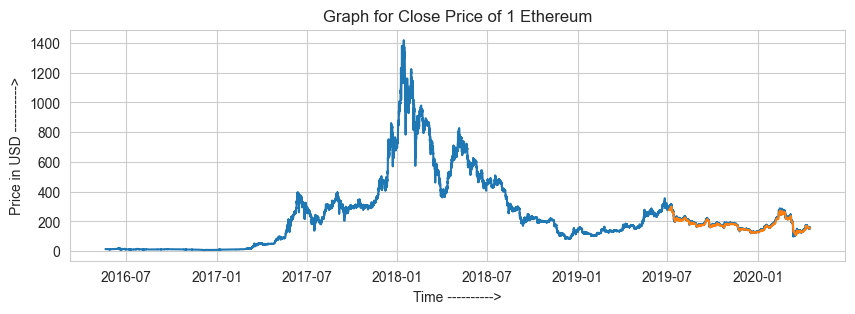

In [21]:
plt.subplots(figsize=(10,3))
sns.lineplot(x=window_dates,y=y)
test_dates_11 = test_dates.reshape(1,-1)
y_pred_11 = y_pred.reshape(1,-1)
sns.lineplot(x=test_dates_11[0],y=y_pred_11[0])
plt.xlabel("Time ---------->")
plt.ylabel("Price in USD ---------->")
plt.title("Graph for Close Price of 1 Ethereum")

In [22]:
print(y_pred_11)

[[275.69196 276.3563  276.85562 ... 154.64336 154.38126 153.7242 ]]


In [23]:
X_test.shape[0]

6851

### Prediction of Future Values

In [24]:
X_2 = X.copy()
y_2 = y.copy()

mms_2 = MinMaxScaler()
X_2_scaled = mms_2.fit_transform(X_2)
y_2_scaled = mms_2.fit_transform(y_2.reshape(-1,1))

In [25]:
train_val_threshold_2 = round(0.8 * X_2.shape[0])
no_of_windows_2 = 240

X_train_2 = X_2_scaled[:train_val_threshold_2]
y_train_2 = y_2_scaled[:train_val_threshold_2]

X_val_2 = X_2_scaled[train_val_threshold_2:]
y_val_2 = y_2_scaled[train_val_threshold_2:]

no_of_train_rows_2 = X_train_2.shape[0]
no_of_val_rows_2 = X_val_2.shape[0]

X_train_2 = X_train_2.reshape(no_of_train_rows_2,1,no_of_windows_2)
X_val_2 = X_val_2.reshape(no_of_val_rows_2,1,no_of_windows_2)

In [26]:
model_2 = tf.keras.models.Sequential(layers=[
    tf.keras.layers.LSTM(units=100, input_shape=(1, window_size)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=1, activation="linear")
])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.mean_squared_error)

In [28]:
model.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=100, batch_size=32, verbose=1, shuffle=True,
          callbacks=tf.keras.callbacks.EarlyStopping(patience=2))

Epoch 1/100
857/857 [==============================] - 6s 5ms/step - loss: 3.5843e-04 - val_loss: 1.1408e-05
Epoch 2/100
857/857 [==============================] - 4s 4ms/step - loss: 3.6432e-04 - val_loss: 1.2861e-05
Epoch 3/100
857/857 [==============================] - 4s 4ms/step - loss: 3.4437e-04 - val_loss: 1.6966e-05


In [29]:
future_start_date = "2020-04-16 01:00:00"
future_end_date = "2020-05-17 01:00:00"

future_dates = pd.date_range(start=future_start_date,end=future_end_date,freq="h").values

In [32]:
input_arr_2 = np.array(X_2_scaled[-1,1:].tolist() + [y_2_scaled[-1][0]])
output_2 = model_2.predict(input_arr_2.reshape(1,1,-1),verbose=0)[0][0]
X_test_2 = []
y_test_2 = []
X_test_2.append(input_arr_2)
y_test_2.append(output_2)
i = 0
print((i+1)," : ",len(future_dates))

for i in range(1,len(future_dates)):
    current_window_2 = X_test_2[i-1]
    input_arr_2 = np.array(current_window_2[1:].tolist() + [y_test_2[i-1]])
    output_2 = model_2.predict(input_arr_2.reshape(1,1,-1),verbose=0)[0][0]
    X_test_2.append(input_arr_2)
    y_test_2.append(output_2)
    print((i+1)," : ",len(future_dates))
    
X_test_2 = np.array(X_test_2)
y_test_2 = np.array(y_test_2)

1  :  745
2  :  745
3  :  745
4  :  745
5  :  745
6  :  745
7  :  745
8  :  745
9  :  745
10  :  745
11  :  745
12  :  745
13  :  745
14  :  745
15  :  745
16  :  745
17  :  745
18  :  745
19  :  745
20  :  745
21  :  745
22  :  745
23  :  745
24  :  745
25  :  745
26  :  745
27  :  745
28  :  745
29  :  745
30  :  745
31  :  745
32  :  745
33  :  745
34  :  745
35  :  745
36  :  745
37  :  745
38  :  745
39  :  745
40  :  745
41  :  745
42  :  745
43  :  745
44  :  745
45  :  745
46  :  745
47  :  745
48  :  745
49  :  745
50  :  745
51  :  745
52  :  745
53  :  745
54  :  745
55  :  745
56  :  745
57  :  745
58  :  745
59  :  745
60  :  745
61  :  745
62  :  745
63  :  745
64  :  745
65  :  745
66  :  745
67  :  745
68  :  745
69  :  745
70  :  745
71  :  745
72  :  745
73  :  745
74  :  745
75  :  745
76  :  745
77  :  745
78  :  745
79  :  745
80  :  745
81  :  745
82  :  745
83  :  745
84  :  745
85  :  745
86  :  745
87  :  745
88  :  745
89  :  745
90  :  745
91  :  745
92  :  7

In [1]:
plt.subplots(figsize=(10,3))
sns.lineplot(x=window_dates,y=y)
test_dates_11 = test_dates.reshape(1,-1)
y_pred_11 = y_pred.reshape(1,-1)
sns.lineplot(x=test_dates_11[0],y=y_pred_11[0])
sns.lineplot(x=future_dates,y=y_test_2.reshape(1,-1)[0])
plt.xlabel("Time ---------->")
plt.ylabel("Price in USD ---------->")
plt.title("Graph for Close Price of 1 Ethereum")

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Graph for Close Price of 1 Ethereum')

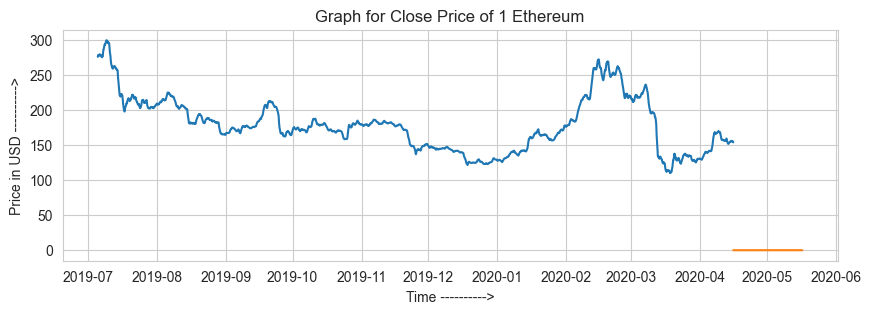

In [34]:
plt.subplots(figsize=(10,3))
test_dates_11 = test_dates.reshape(1,-1)
y_pred_11 = y_pred.reshape(1,-1)
sns.lineplot(x=test_dates_11[0],y=y_pred_11[0])
sns.lineplot(x=future_dates,y=y_test_2.reshape(1,-1)[0])
plt.xlabel("Time ---------->")
plt.ylabel("Price in USD ---------->")
plt.title("Graph for Close Price of 1 Ethereum")